In [29]:
import os
import re
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm=ChatGroq(model="qwen/qwen3-32b")
result=llm.invoke("Hi!!!")
raw=result.content

# Remove the <think>...</think> section
cleaned = re.sub(r"<think>.*?</think>\s*", "", raw, flags=re.DOTALL)
cleaned

"Hi there! 😊 How can I assist you today? Let me know if there's something you'd like to explore or discuss!"

In [30]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    topic: str
    descriptions: str
    pros: str
    cons: str
    summary: str

In [31]:
# Nodes
def generate_descriptions(state: State):
    """Generate descriptions"""
    msg = llm.invoke(f"Generate description on following topic {state['topic']}")
    return {"descriptions": re.sub(r"<think>.*?</think>\s*", "", msg.content, flags=re.DOTALL)}

def generate_pros(state: State):
    """Generate pros"""
    msg = llm.invoke(f"Give pros of following topic {state['topic']}")
    return {"pros": re.sub(r"<think>.*?</think>\s*", "", msg.content, flags=re.DOTALL)}

def generate_cons(state: State):
    """Generate cons """
    msg = llm.invoke(f"Give cons of following topic {state['topic']}")
    return {"cons": re.sub(r"<think>.*?</think>\s*", "", msg.content, flags=re.DOTALL)}

def generate_summary(state: State):
    """Summary of the topic with description, pros and cons"""
    msg = llm.invoke(
        f"Generate summery on following topic {state['topic']} using these elements:\n"
        f"Description: {state['descriptions']}\n"
        f"Pros: {state['pros']}\n"
        f"Cons: {state['cons']}\n")
    return {"summary": re.sub(r"<think>.*?</think>\s*", "", msg.content, flags=re.DOTALL)}


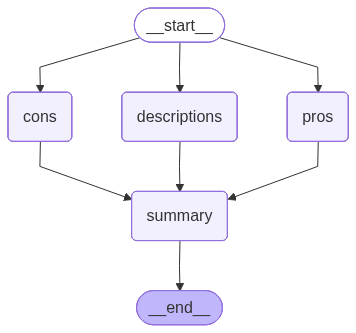

In [32]:
# Build the graph
graph = StateGraph(State)
graph.add_node("descriptions", generate_descriptions)
graph.add_node("pros", generate_pros)
graph.add_node("cons", generate_cons)
graph.add_node("summary", generate_summary)

# Define edges 
graph.add_edge(START, "descriptions")
graph.add_edge(START, "pros")
graph.add_edge(START, "cons")
graph.add_edge("descriptions", "summary")
graph.add_edge("pros", "summary")
graph.add_edge("cons", "summary")
graph.add_edge("summary", END)

# Compile and run
compiled_graph = graph.compile()
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [33]:
state = {"topic": "Home office"}
result = compiled_graph.invoke(state)
print(result["summary"])

**Summary: The Home Office – Balancing Productivity, Comfort, and Challenges**  

A **home office** is a tailored workspace designed to enhance productivity and well-being for remote or hybrid work. It integrates **ergonomic furniture** (e.g., adjustable desks, supportive chairs), **reliable technology** (computing devices, high-speed internet), and **ergonomic design** to prioritize physical health. Thoughtful lighting, natural elements, and personalized decor further foster a motivating environment.  

**Advantages** include **flexibility** (customizable schedules, saved commuting time), **cost savings** (reduced expenses on transport and meals), and **improved work-life balance** through physical and temporal boundaries. It also boosts **productivity** via fewer distractions and a personalized setup, while promoting **health** through ergonomic adjustments and reduced stress.  

However, challenges like **blurred work-life boundaries**, **social isolation**, and **technical limitati